# Fitted Parameter Accuracy

This notebook examins the accuraccy of fitted SN parameters when assuming different levels of atmospheric variabitily in the fitting process.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy.stats.stats import pearsonr
from tqdm import tqdm

from snat_sim.constants import betoule_alpha, betoule_beta
from snat_sim.utils.time_series import datetime_to_sec_in_year


## Parsing Data

Results from the analysis pipeline are written to disk over multiple files. We read data from each file and concatenate the results. 

Values that are not fit for are masked using the value `-99.99`. For conveniance, we replace these values with `nan` in the below example. 

For a full overview of the output file data model, see the [data model documentation](https://lsstdesc.org/SN-PWV/overview/data_model.html).


In [2]:
def add_derived_values(pipeline_data):
    """Calculate useful values and add them to a dataframe of pipeline data
    
    Args:
        pipeline_data (DataFrame): Pipeline data returned by ``load_pipeline_data``
        
    Returns:
        A copy of the given dataframe with added columns
    """
    
    pipeline_data = pipeline_data.copy()
    
    # Add residuals for each parameter fit
    for param in ('z', 't0', 'x0', 'x1', 'c'):
        pipeline_data[f'delta_{param}'] = pipeline_data[f'fit_{param}'] - pipeline_data[param]
        pipeline_data[f'delta_{param}_norm'] = pipeline_data[f'delta_{param}'] / pipeline_data[f'{param}']
    
    # Add residuals in stretch color correction
    pipeline_data['delta_corr'] = pipeline_data.delta_x0 - (betoule_alpha * pipeline_data.delta_x1) + (betoule_beta * pipeline_data.delta_c)
    pipeline_data['corr'] = pipeline_data.x0 - (betoule_alpha * pipeline_data.x1) + (betoule_beta * pipeline_data.c)
    pipeline_data['delta_corr_norm'] = pipeline_data[f'delta_corr'] / pipeline_data['corr']

    return pipeline_data


In [3]:
def get_combined_data_table(directory, key, pattern='*.h5', file_limit=float('inf')):
    """Return a single data table from directory of HDF5 files
    
    Returns concatenated tables from each of the files.
    
    Args:
        directory (Path): The directory to parse data files from
        key        (str): Key of the table in the HDF5 files
        pattern    (str): Include results from all files matching the regex pattern
        file_limit (int): Only parse up to the given number of files matching ``pattern``
        
    Returns:
        A pandas datafram with pipeline data
    """

    if not (h5_files := list(directory.glob(pattern))):
        raise ValueError(f'No h5 files found in {directory}')
    
    dataframes = []    
    for i, file in tqdm(enumerate(h5_files), total=min(len(h5_files), file_limit)):
        if i >= file_limit:
            break
        
        with pd.HDFStore(file, 'r') as datastore:
            dataframes.append(datastore.get(key))
            
    return pd.concat(dataframes).set_index('snid')


def load_pipeline_data(directory, pattern='*.h5', derived=True, file_limit=float('inf')):
    """Return the combined input and output parameters from a pipeline run
    
    Args:
        directory (Path): The directory to parse data files from
        pattern    (str): Include results from all files matching the regex pattern
        derived   (bool): Optionally add dynamically derived values
        file_limit (int): Only parse up to the given number of files matching ``pattern`` 
        
    Returns:
        A pandas datafram with pipeline data
    """
    
    sim_params = get_combined_data_table(directory, '/simulation/params', pattern=pattern, file_limit=file_limit)
    fit_results = get_combined_data_table(directory, '/fitting/params', pattern=pattern, file_limit=file_limit)
    fit_status = get_combined_data_table(directory, 'message', pattern=pattern, file_limit=file_limit)

    # The join order is important here. Left most tables are a superset of rightmost tables
    pipeline_data = fit_status.join(fit_results).join(sim_params)

    # Join results for failed fit results will be nan.
    return_data = pipeline_data.replace(-99.99, np.nan)
    if derived:
        return_data = add_derived_values(return_data)
        
    return return_data


In [4]:
data_dir = Path('.').resolve().parent / 'data' / 'analysis_runs'


We load data from different simulation and fitting conditions. The fitting process may not be able to find a successful minimum for each lgiht-curve. We print a summary of the success rate.

In [5]:
pipeline_data = load_pipeline_data(data_dir / 'pwv_sim_epoch_fit_4')

print('Summary of simulation success for SNe:')
pipeline_data.success.value_counts()


100%|██████████| 326/326 [00:06<00:00, 46.75it/s]


Summary of simulation success for SNe:


True     2997557
False     255295
Name: success, dtype: int64

In [6]:
pipeline_data.columns


Index(['success', 'message', 'fit_z', 'fit_t0', 'fit_x0', 'fit_x1', 'fit_c',
       'fit_pwv', 'err_z', 'err_t0', 'err_x0', 'err_x1', 'err_c', 'err_pwv',
       'chisq', 'ndof', 'apparent_bessellb', 'absolute_bessellb', 'ra', 'dec',
       't0', 'x1', 'c', 'z', 'x0', 'delta_z', 'delta_z_norm', 'delta_t0',
       'delta_t0_norm', 'delta_x0', 'delta_x0_norm', 'delta_x1',
       'delta_x1_norm', 'delta_c', 'delta_c_norm', 'delta_corr', 'corr',
       'delta_corr_norm'],
      dtype='object')

## Accuracy of Fitted Parameters


We examine the distribution of fitted parameter residuals for different fitting conditions.

In [7]:
def clean_data(data):
    """Drop SN with failed fits and apply quality cuts
    
    Cuts defined here are applied to all plots in the remainder
    of the notebook.
    
    Args:
        data (DataFrame): Pipeline output data
    
    Returns:
        A copy of the data that has been cleaned
    """
    
    return data[data.success]


In [8]:
def plot_parameter_distribution(
    data, 
    params=('z', 'x0', 'x1', 'c', 'ra', 'dec'),
    xlims=((0, .9), (0, 3.0e-5), (-3, 3), (-.3, .3), (0, 360), (-70, 10)),
    bins=(100, np.linspace(0, 3.0e-5, 100), 100, 100, 100, 100),
    sharey=True,
    figsize=(20, 5)
):
    """Plot histograms for the given dataframe / column names
    
    Args:
        data (DataFrame): Pipeline data to use for the plot
        params   (tuple): Tuple of parameter names to plot distributions for
        bins       (int): Number of bins to use when building histograms
        figsize  (tuple): Size of the generated figure
    """
    
    data = clean_data(data)
    
    fig, axes = plt.subplots(1, len(params), figsize=figsize, sharey=sharey)
    for param, xlim, binn, axis in zip(params, xlims, bins, axes):
        axis_data = data[param]
        median = axis_data.median()
        std = axis_data.std()
        
        hist = axis.hist(axis_data, bins=binn, label=f'STD {std:.2f}')
        axis.axvline(median, linestyle='--', color='k', label=f'Median: {median:.2f}')
        
        axis.set_xlabel(param, fontsize=16)
        axis.set_xlim(xlim)
        axis.legend()

    axes[0].set_ylabel('Number of SNe')
    

In [9]:
def plot_parameter_accuracy(
    data, 
    params=('t0', 'x0', 'x1', 'c', 'corr'),
    bins=np.linspace(-1, 1, 200),
    sharey=False,
    figsize=(26, 5)
):
    """Plot histograms of the normalized difference between 
    simulated and fitted model parameters.
    
    Args:
        data (DataFrame): Pipeline data to use for the plot
        params   (tuple): Tuple of parameter names to plot distributions for
        bins     (Array): Bins to use when building histograms
        figsize  (tuple): Size of the generated figure
    """
        
    data = clean_data(data)
    
    fig, axes = plt.subplots(1, len(params), figsize=figsize, sharey=sharey)
    for param, axis in zip(params, axes):
        xmin = min(bins)
        xmax = max(bins)
        
        axis_data = data[f'delta_{param}_norm']
        axis_data = axis_data[xmin <= axis_data][axis_data <= xmax]
        median = axis_data.median()
        mean = axis_data.mean()
        std = axis_data.std()
        
        hist = axis.hist(axis_data, bins=bins, label=f'STD {std:.2f}')
        axis.axvline(median, linestyle='--', color='k', label=f'Median: {median:.2f}')
        
        axis.set_xlabel(r'$\frac{' + param + r'_{sim} - ' + param + '_{fit}}{' + param + '_{sim}}$', fontsize=16)
        axis.set_xlim(xmin, xmax)
        axis.legend()
        
    axes[0].set_ylabel('Number of SNe')


Distribution of input parameters


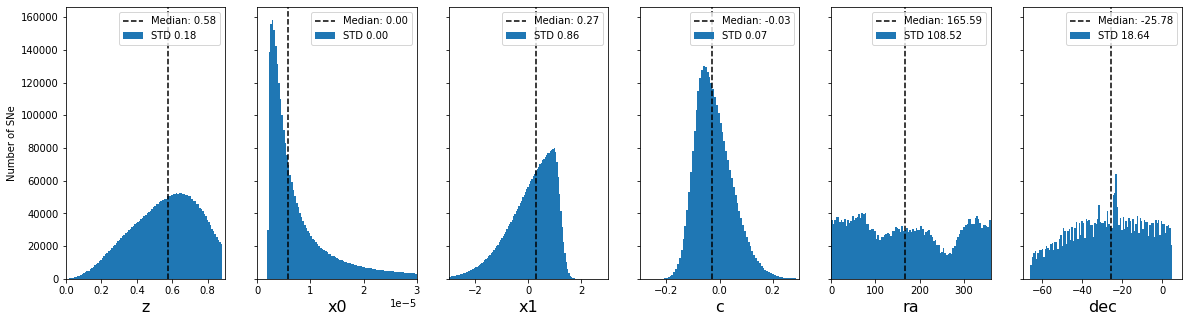

Distribution of Fitted parameters


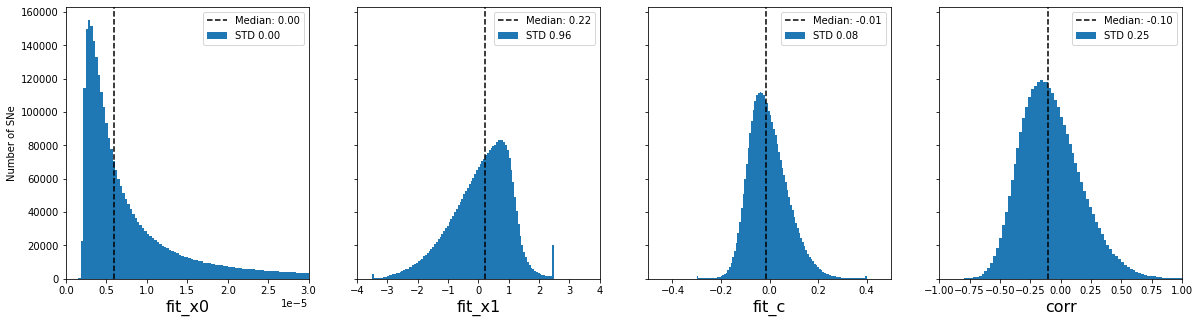

Accuracy of fitted parameters (alpha = 0.141, beta = 3.101)


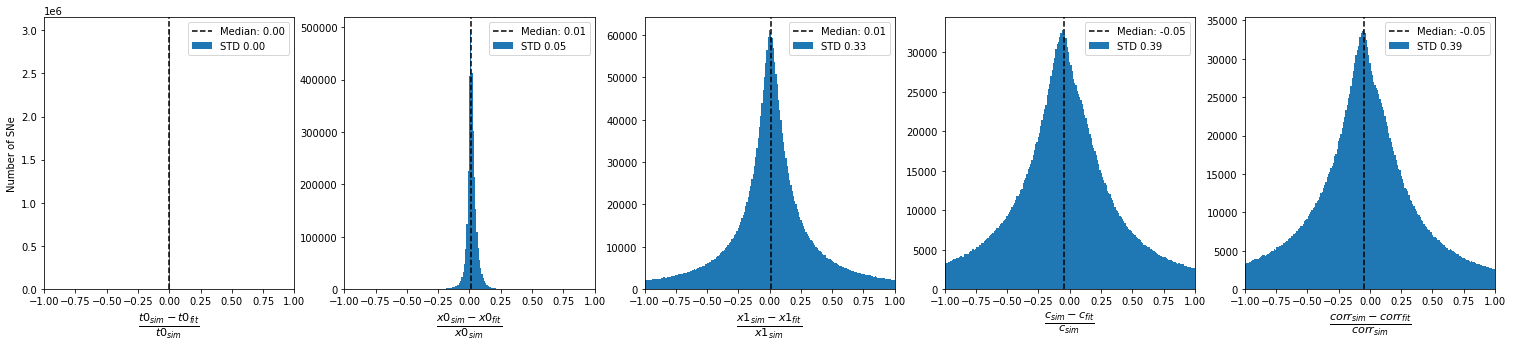

In [10]:
print('Distribution of input parameters')
plot_parameter_distribution(pipeline_data)
plt.show()

print('Distribution of Fitted parameters')
plot_parameter_distribution(
    pipeline_data, 
    params=('fit_x0', 'fit_x1', 'fit_c', 'corr'), 
    xlims=((0, 3.0e-5), (-4, 4), (-.5, .5), (-1, 1)),
    bins=(np.linspace(0, 3.0e-5, 100), 100, 100, 100),
)
plt.show()

print(f'Accuracy of fitted parameters (alpha = {betoule_alpha}, beta = {betoule_beta})')
plot_parameter_accuracy(pipeline_data)


## Correlation Between Residuals and SN Properties

We check for correlations between residuals in the fitted parameters and other supernova properties.

In [11]:
def calc_correlations(data, params, properties):
    """Calculate the pearson correlation coefficiant between the specified parameters
    
    Args:
        data   (DataFrame): Pipeline data to use for the plot
        params     (tuple): Model parameters to calculate covariance for
        properties (tuple): Name of SN properties to calculate covariance with
        
    Returns:
        - A dataframe with covariance values
        - A dataframe with p values
    """
    
        
    data = clean_data(data)
    
    corr_for_param = dict()
    p_for_param = dict()
    for param in params:

        corr_for_prop = dict()
        p_for_prop = dict()
        for prop in properties:
            x = data[prop]
            y = data[param]
            corr_for_prop[prop], p_for_prop[prop] = pearsonr(x, y)

        corr_for_param[param] = pd.Series(corr_for_prop)
        p_for_param[param] = pd.Series(p_for_prop)

    return pd.DataFrame(corr_for_param), pd.DataFrame(p_for_param)


In [12]:
def plot_correlations(
    corr_data,
    params,
    properties,
    figsize=(8, 8),
    vmin=None,
    vmax=None,
    label='',
    cmap=None
):
    """Create a heatmap of correlation data
    
    Args:
        corr_data (DataFrame): Data returned from ``calc_correlations``
        params        (tuple): Model parameters used to calculate covariance
        properties    (tuple): Name of SN properties used to calculate covariance
        figsize       (tuple): Size of the generated figure
        vmin            (int): Lower bound of the color bar
        vmax            (int): Upper bound of the color bar
        label           (str): The label of the color bar
        cmap            (str): Name of the matplotlib color map to use
    """
    
    fig, axis = plt.subplots(figsize=figsize)
    im = axis.imshow(corr_data, vmin=vmin, vmax=vmax, cmap=cmap)

    cbar = axis.figure.colorbar(im, ax=axis)
    cbar.ax.set_ylabel(label, rotation=-90, va="bottom")

    axis.set_xticks(np.arange(corr_data.shape[1]))
    axis.set_yticks(np.arange(corr_data.shape[0]))
    axis.set_xticklabels(params)
    axis.set_yticklabels(properties)
    
    for (j,i),label in np.ndenumerate(corr_data):
        axis.text(i,j,f'{label:.2f}',ha='center',va='center')
    

In [13]:
def calculate_and_plot_covariances(data, params, properties):
    """Calculate and plot the pearson correlation coefficiant between the specified parameters
    
    Args:
        data   (DataFrame): Pipeline data to use for the plot
        params     (tuple): Model parameters to calculate covariance for
        properties (tuple): Name of SN properties to calculate covariance with
        
    Returns:
        - A dataframe with covariance values
        - A dataframe with p values
    """
    
    corr, p = calc_correlations(data, params, properties)

    print('Correlation matrix:')
    print(corr)
    plot_correlations(corr, params, properties, vmin=-.3, vmax=.3, label='Corrolation Strength', cmap='coolwarm_r')
    plt.show()

    print('p-value matrix:')
    print(p)
    plot_correlations(p, params, properties, label='p value', cmap='Blues_r', vmax=0.05)
    plt.show()
    

Correlation matrix:
            z        t0        x0        x1         c        ra       dec
z    1.000000  0.010859 -0.232824  0.088666 -0.168410 -0.015384 -0.014494
t0   0.010859  1.000000 -0.002231 -0.001881 -0.000683  0.013124 -0.059515
x0  -0.232824 -0.002231  1.000000 -0.013036  0.020851  0.001073  0.002149
x1   0.088666 -0.001881 -0.013036  1.000000  0.016996  0.002028  0.002011
c   -0.168410 -0.000683  0.020851  0.016996  1.000000 -0.004753 -0.002976
ra  -0.015384  0.013124  0.001073  0.002028 -0.004753  1.000000 -0.035834
dec -0.014494 -0.059515  0.002149  0.002011 -0.002976 -0.035834  1.000000


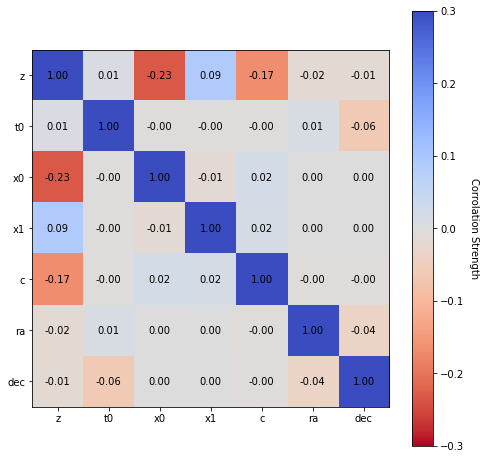

p-value matrix:
                 z             t0             x0             x1  \
z     0.000000e+00   7.477775e-79   0.000000e+00   0.000000e+00   
t0    7.477775e-79   0.000000e+00   1.118257e-04   1.124488e-03   
x0    0.000000e+00   1.118257e-04   0.000000e+00  8.514307e-113   
x1    0.000000e+00   1.124488e-03  8.514307e-113   0.000000e+00   
c     0.000000e+00   2.372354e-01  1.995425e-285  2.403584e-190   
ra   2.613751e-156  2.640490e-114   6.311889e-02   4.449269e-04   
dec  5.628422e-139   0.000000e+00   1.989714e-04   4.979826e-04   

                 c             ra            dec  
z     0.000000e+00  2.613751e-156  5.628422e-139  
t0    2.372354e-01  2.640490e-114   0.000000e+00  
x0   1.995425e-285   6.311889e-02   1.989714e-04  
x1   2.403584e-190   4.449269e-04   4.979826e-04  
c     0.000000e+00   1.883754e-16   2.564001e-07  
ra    1.883754e-16   0.000000e+00   0.000000e+00  
dec   2.564001e-07   0.000000e+00   0.000000e+00  


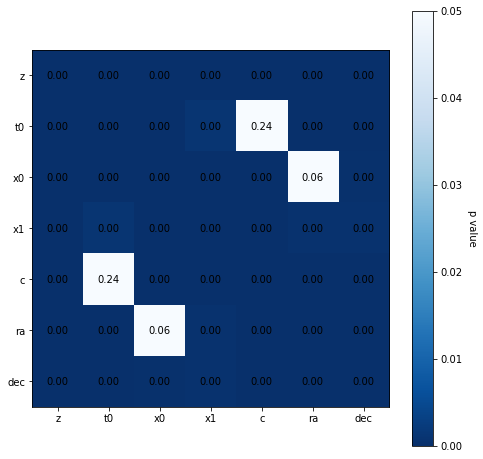

In [14]:
sn_properties = ('z', 't0', 'x0', 'x1', 'c', 'ra', 'dec')
calculate_and_plot_covariances(pipeline_data, sn_properties, sn_properties)


/ihome/sam/djp81/.virtualenvs/SN-PWV/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Correlation matrix:
     delta_t0  delta_x0  delta_x1   delta_c  delta_corr
z         NaN  0.043071  0.017826 -0.027119   -0.033417
t0        NaN  0.001783 -0.000946 -0.009095   -0.007989
x0        NaN -0.242086  0.001680  0.021100    0.018760
x1        NaN  0.001014  0.056189  0.046973    0.017409
c         NaN -0.010326 -0.002723  0.084415    0.079495
ra        NaN -0.000574 -0.002343 -0.011470   -0.009540
dec       NaN -0.002764 -0.006229  0.048143    0.047511


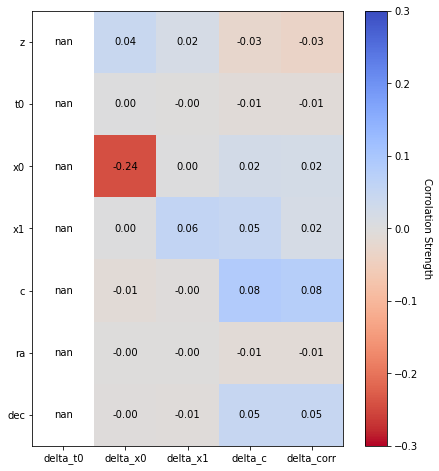

p-value matrix:
     delta_t0      delta_x0       delta_x1        delta_c     delta_corr
z         NaN  0.000000e+00  3.548543e-209   0.000000e+00   0.000000e+00
t0        NaN  2.017001e-03   1.013620e-01   7.228380e-56   1.653258e-43
x0        NaN  0.000000e+00   3.621404e-03  3.059691e-292  1.829161e-231
x1        NaN  7.925375e-02   0.000000e+00   0.000000e+00  1.291382e-199
c         NaN  1.755538e-71   2.427070e-06   0.000000e+00   0.000000e+00
ra        NaN  3.200252e-01   4.979333e-05   9.238839e-88   2.733502e-61
dec       NaN  1.703890e-06   4.097226e-27   0.000000e+00   0.000000e+00


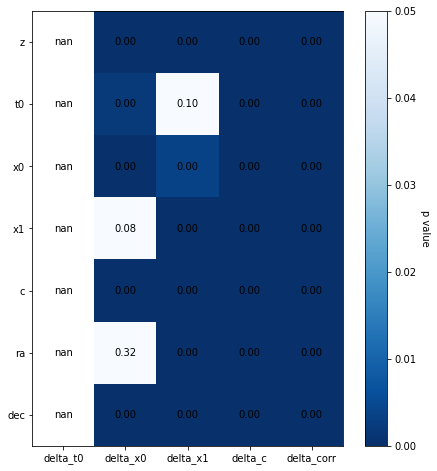

In [15]:
residuals = ('delta_t0', 'delta_x0', 'delta_x1', 'delta_c', 'delta_corr')
calculate_and_plot_covariances(pipeline_data, residuals, sn_properties)


In [16]:
def density_corner_plot(
    data,
    y_vals=('z', 'x0', 'x1', 'c', 'ra', 'dec', 'corr'),
    y_lims=((0, 0.9), (0, 3.0e-05), (-4, 4), (-0.25, 0.25), (0, 360), (-70, 10), (-1, 1)),
    y_bins=200,
    x_vals=('delta_t0_norm', 'delta_x0_norm', 'delta_x1_norm', 'delta_c_norm', 'delta_corr_norm'),
    x_lims=((-0.75, 0.75),) * 5,
    x_bins=200,
    color_bins=50,
    cmap='Blues',
    figsize=(20, 20)
):
    """Plot 2d histogram of the normalized difference between 
    simulated and fitted model parameters relative to a given 
    dataframe column.
    
    Args:
        data (DataFrame): Pipeline data to use for the plot
        params   (tuple): Tuple of parameter names to plot distributions for
        x_val      (str): Name of column to use for the x axis
        figsize  (tuple): Size of the generated figure
        bins       (int): Number of bins to use in the histogram
        cmap       (str): Name of the color map to use
    """
    
    data = clean_data(data)
    
    num_xvals = len(x_vals)
    num_yvals = len(y_vals)
    num_columns = num_xvals + 1
    num_rows = len(y_vals) + 1

    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(
        num_rows,
        num_columns,
        width_ratios=(6,) * num_xvals + (3,),
        height_ratios=(3,) + (6,) * num_yvals,
        # left=0.1,
        # right=0.9,
        # bottom=0.1,
        # top=0.9,
        # wspace=0.05,
        # hspace=0.1
    )
    
    # Iterate over center subplots and add 2d histograms
    for row_idx, (y_val, y_lim) in enumerate(zip(y_vals, y_lims), start=1):
        for col_idx, (x_val, x_lim) in enumerate(zip(x_vals, x_lims)):
            
            # Drop nans 
            plt_data = data.dropna(subset=[x_val, y_val])
            x_data = plt_data[x_val]
            y_data = plt_data[y_val]

            ax = fig.add_subplot(gs[row_idx, col_idx])
            ax.hist2d(x_data, y_data, bins=color_bins, cmap=cmap, range=(x_lim, y_lim))
            ax.set_xlim(x_lim)
            ax.set_ylim(y_lim)
            
            if col_idx == 0:
                ax.set_ylabel(y_val, fontsize=16)
        
            if row_idx == num_yvals:
                ax.set_xlabel(x_val, fontsize=16)

    
    # Iterate over top most row and add histograms
    for col_idx, (x_val, x_lim) in enumerate(zip(x_vals, x_lims)):
        top_of_column_ax = fig.add_subplot(gs[0, col_idx])
        top_of_column_ax.hist(data[x_val], bins=np.linspace(*x_lim, x_bins))
        top_of_column_ax.set_xlim(x_lim)

    # Iterate over right most column and add histograms
    for row_idx, (y_val, y_lim) in enumerate(zip(y_vals, y_lims), start=1):
        end_of_row_ax = fig.add_subplot(gs[row_idx, num_xvals])
        end_of_row_ax.hist(data[y_val], bins=np.linspace(*y_lim, y_bins), orientation='horizontal')
        end_of_row_ax.set_ylim(y_lim)


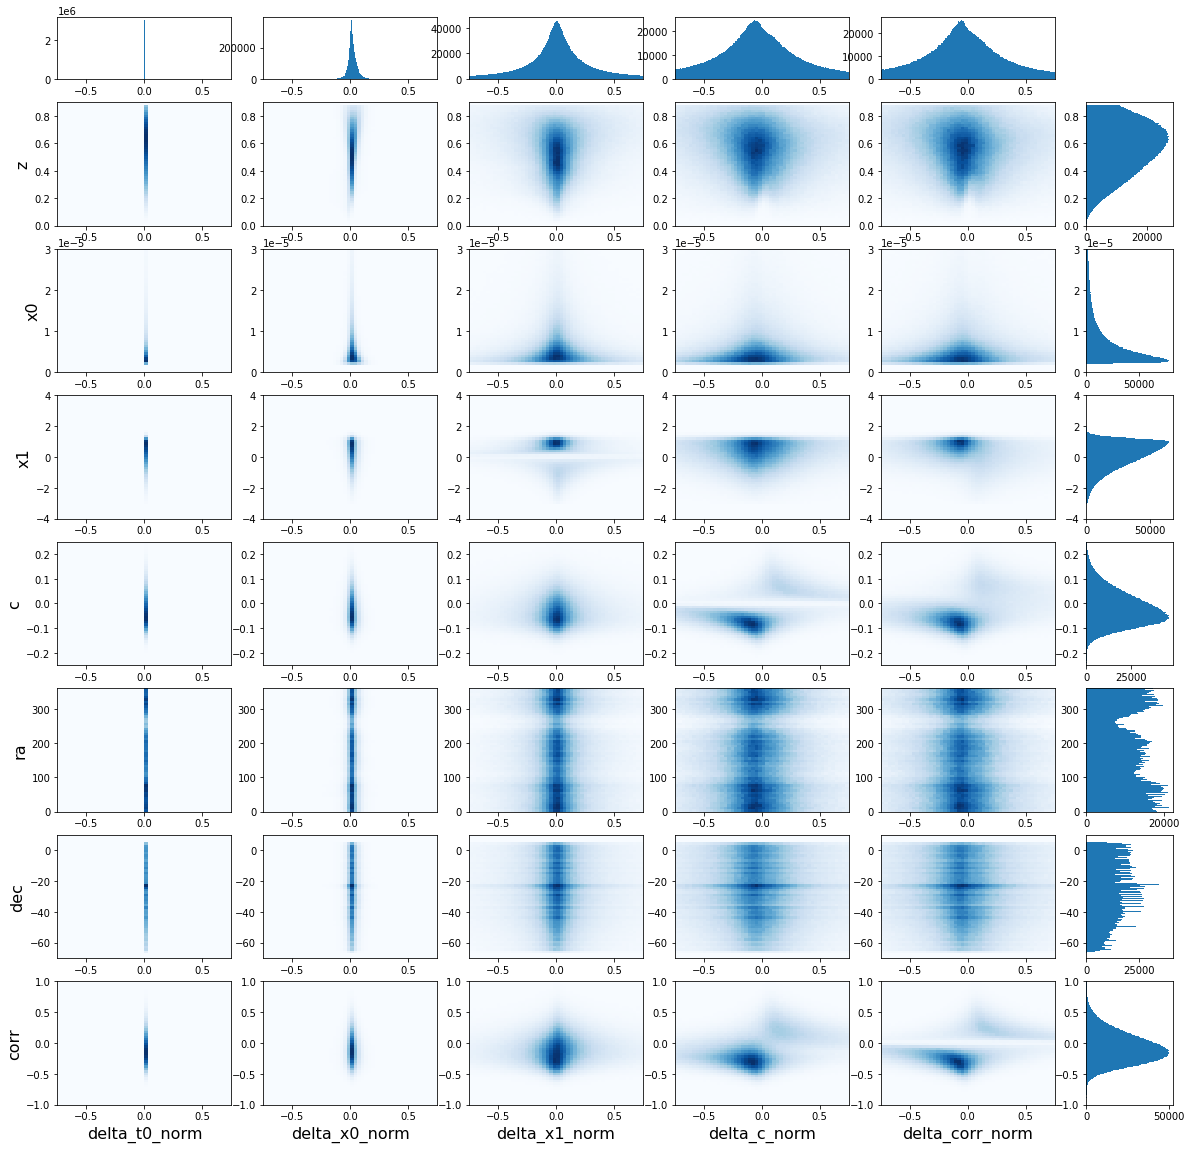

In [17]:
density_corner_plot(pipeline_data)


In [18]:
def plot_ra_dec(data, param, cmap='bwr'):
    """Plot normalized residuals on a sky map
    
    Args:
        data (DataFrame): Pipeline data to use for the plot
        param      (str): Name of the parameter to plot accuracy for
        cmap       (str): Name of the color map to use
    """
    
    data = clean_data(data)
    resid = data[param]
    sn_coord = SkyCoord(data['ra'], data['dec'], unit=u.deg).galactic
    
    plt.figure(figsize=(10, 5))
    plt.subplot(111, projection='aitoff')
    plt.grid(True)

    scat = plt.scatter(
        sn_coord.l.wrap_at('180d').radian, 
        sn_coord.b.radian, c=resid, 
        vmin=-1, 
        vmax=1, 
        s=1, 
        cmap=cmap)
    
    plt.colorbar(scat).set_label(f'Accuracy in {param} (Median = {np.median(resid):.2f})', rotation=270, labelpad=15)


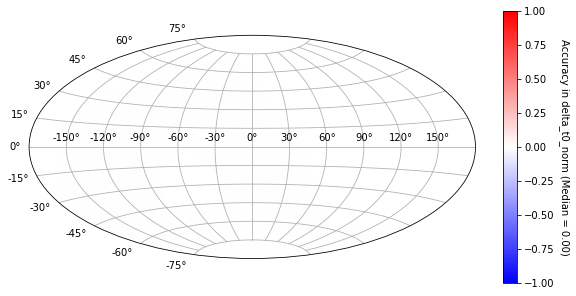

In [19]:
plot_ra_dec(pipeline_data, 'delta_t0_norm')


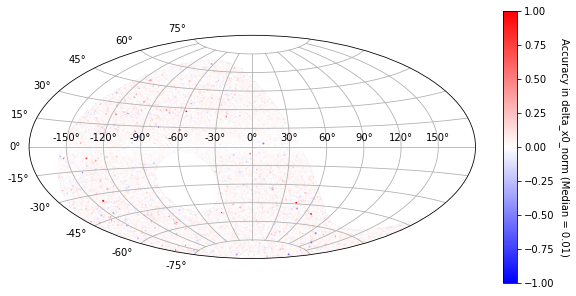

In [20]:
plot_ra_dec(pipeline_data, 'delta_x0_norm')


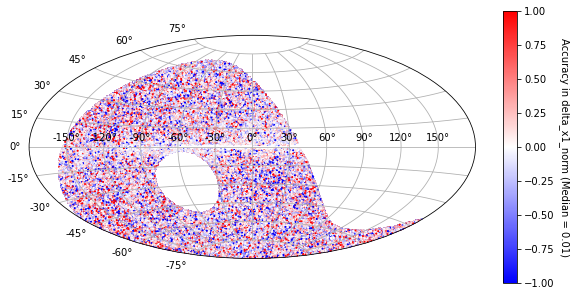

In [21]:
plot_ra_dec(pipeline_data, 'delta_x1_norm')


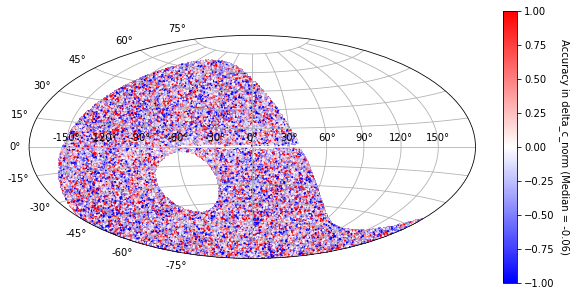

In [22]:
plot_ra_dec(pipeline_data, 'delta_c_norm')
